RISE-xai-techniques-Getting_Started-presoftmax_adversarial_attacks_v1

This notebook demonstrates adversarial attacks on gradient-based attribution methods
(e.g., Grad-CAM) that use pre-softmax outputs. It builds on repositories:
- https://github.com/mlerma54/adversarial-attacks-on-saliency-maps
- https://github.com/lisadunlap/xai-techniques

The goal is to show how to fool saliency maps produced by explainable AI techniques.


Clone the adversarial attacks repository for code and data

In [ ]:
!git clone https://github.com/mlerma54/adversarial-attacks-on-saliency-maps.git

Cloning into 'adversarial-attacks-on-saliency-maps'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 11.36 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (10/10), done.


Provide your system-specific paths below

In [ ]:
root = '/content/adversarial-attacks-on-saliency-maps/'
images_dir = root + 'images/'


Verify the repository and image directories exist

In [ ]:
import os

for d in [root, images_dir]:
  print(d)
  assert(os.path.isdir(d))

/content/adversarial-attacks-on-saliency-maps/
/content/adversarial-attacks-on-saliency-maps/images/


Set the original image and model to use

In [ ]:
orig_image = images_dir + 'dog-and-cat.jpg'
orig_image

'/content/adversarial-attacks-on-saliency-maps/images/dog-and-cat.jpg'

In [ ]:
orig_model = 'vgg19'  # Alternative: 'resnet18'

Clone repository containing various XAI techniques implementations

In [ ]:
!git clone https://github.com/lisadunlap/xai-techniques.git

Cloning into 'xai-techniques'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 274 (delta 67), reused 269 (delta 62), pack-reused 0 (from 0)
Receiving objects: 100% (274/274), 21.21 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:
%cd /content/xai-techniques

/content/xai-techniques


Install the techniques package

In [ ]:
!pip install -e .

Obtaining file:///content/xai-techniques
  Preparing metadata (setup.py) ... done
  Running setup.py develop for xai_techniques


In [ ]:
%pwd

'/content/xai-techniques/techniques'

In [ ]:
%cd techniques

/content/xai-techniques/techniques


Import required libraries for image processing, model manipulation, and visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torchvision import models, datasets
from torch.autograd import Variable

from techniques.utils import get_displ_img

Note: If using Python 3.10+, a modification in 'gcam.py' might be required
Reference: https://github.com/skorch-dev/skorch/issues/895


Modifications to do on the files:

[https://github.com/skorch-dev/skorch/issues/895](https://github.com/skorch-dev/skorch/issues/895)
```
python3.10 -c "from collections.abc import Sequence"
```
/content/xai-techniques/techniques/Grad_CAM/gcam.py
```
# !/usr/bin/env python
# coding: utf-8
#
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

from collections import OrderedDict
from collections.abc import Sequence

```






Install additional dependencies needed for explanation methods

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bbf719a9e285179b47339700f0ca15678dbf74e063c2e9fb48a8d5b5c759cf11
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Import functions to generate different explanation heatmaps

In [ ]:
from techniques.generate_grounding import gen_grounding, gen_all_groundings
save_path='../cat_dog/'

Set image dimensions for model input

In [ ]:
width = height = 224

## Sample Image

Load and preprocess the sample image
TODO: Fix color channel issues if any arise in display

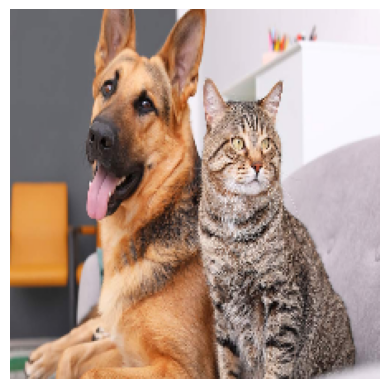

In [ ]:

displ_img = cv2.cvtColor(cv2.imread(orig_image), cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(displ_img, (width, height))
plt.axis('off')
plt.imshow(resized_image)

## === Generate Mask/Heatmap Explanation Methods ===

### Grad-CAM explanations for dog class indices, both explicit and indexed targets

result path: ../cat_dog/dog/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 112MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in 

	#0: German_shepherd (0.24988)
saving explanation mask....

saved to ../cat_dog/dog/gcam-vgg19


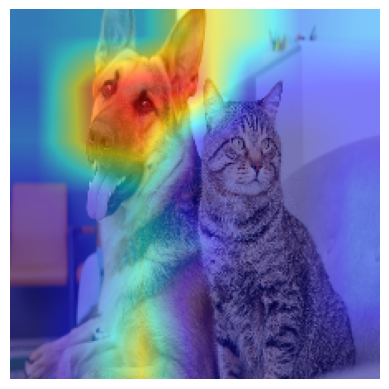

In [ ]:
#generate image wrt a specific class index
gcam_expl_dog = gen_grounding(resized_image,
                              'gcam',
                              orig_model,
                              target_index=1,
                              show=True,
                              save=True,
                              save_path=save_path+'dog',
                              device=0,
                              index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


result path: ../cat_dog/dog/


100%|██████████| 44.7M/44.7M [00:01<00:00, 25.2MB/s]


saving explanation mask....

saved to ../cat_dog/dog/gcam-resnet18


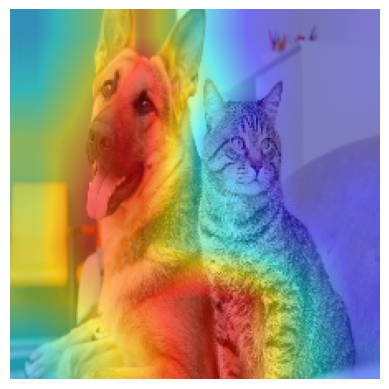

In [ ]:
#generate image wrt a specific class index
gcam_expl_dog = gen_grounding(resized_image,
                              'gcam',
                              orig_model,
                              target_index=242,
                              show=True,
                              save=True,
                              save_path=save_path+'dog',
                              device=0,
                              index=True)

Grad-CAM explanation for cat class

result path: ../cat_dog/cat/
saving explanation mask....

saved to ../cat_dog/cat/gcam-vgg19


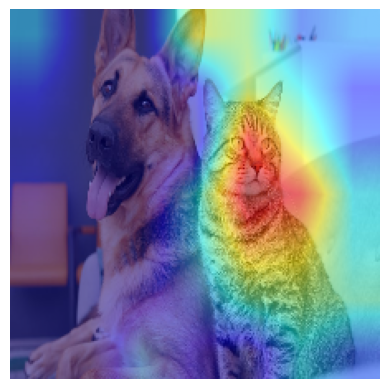

In [ ]:
#generate image wrt a specific class index
gcam_expl_cat = gen_grounding(resized_image,
                              'gcam',
                              orig_model,
                              target_index=282,
                              show=True,
                              save=True,
                              save_path=save_path+'cat',
                              device=0,
                              index=True)

### LIME explanation for dog and cat classes

result path: ../cat_dog/dog/


  0%|          | 0/1000 [00:00<?, ?it/s]

lime classsification: 235
finished lime explanation
saving explanation mask....

saved to ../cat_dog/dog/lime-vgg19


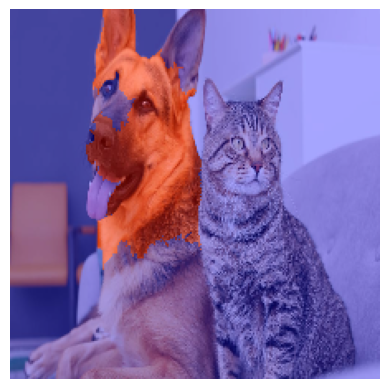

In [ ]:
lime_expl= gen_grounding(resized_image,
                         'lime',
                         orig_model,
                         target_index=1,
                         show=True,
                         save=True,
                         save_path=save_path+'dog',
                         device=0)

result path: ../cat_dog/cat/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

lime classsification: 771
finished lime explanation
saving explanation mask....

saved to ../cat_dog/cat/lime-vgg19


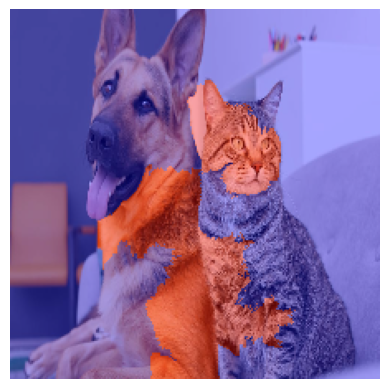

In [ ]:
lime_expl_cat= gen_grounding(resized_image,
                             'lime',
                             orig_model,
                             target_index=282,
                             show=True,
                             save=True,
                             save_path=save_path+'cat',
                             device=0,
                             index=True)

### RISE explanation for dog and cat classes

In [ ]:
rise_expl = gen_grounding(resized_image,
                          'rise',
                          orig_model,
                          target_index=1,
                          show=True,
                          save=True,
                          save_path=save_path+'dog',
                          device=0)

result path: ../cat_dog/dog/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Generating filters: 100%|██████████| 6000/6000 [00:14<00:00, 401.89it/s]


Masks are generated.
finished RISE
saving explanation mask....

saved to ../cat_dog/dog/rise-vgg19


TODO: fix indexing for cat class in RISE explanations

result path: ../cat_dog/cat/


Generating filters: 100%|██████████| 6000/6000 [00:14<00:00, 423.33it/s]


Masks are generated.
finished RISE
saving explanation mask....

saved to ../cat_dog/cat/rise-vgg19


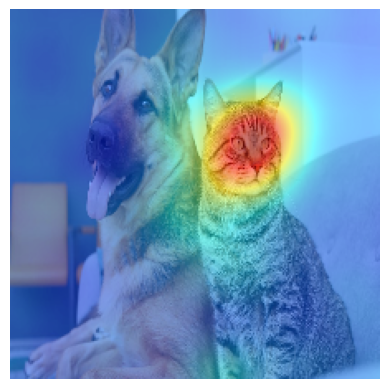

In [ ]:

rise_expl_cat = gen_grounding(resized_image,
                              'rise',
                              orig_model,
                              target_index=2,
                              show=True,
                              save=True,
                              save_path=save_path+'cat',
                              device=0)

# === Generate Saliency Map Explanation Methods ===

### Integrated Gradients explanations for dog and cat classes

result path: ../cat_dog/dog/
integrated gradients clasification: boxer
finished Integrated Gradients explanation
changed
saving explanation mask....

saved to ../cat_dog/dog/ig-vgg19


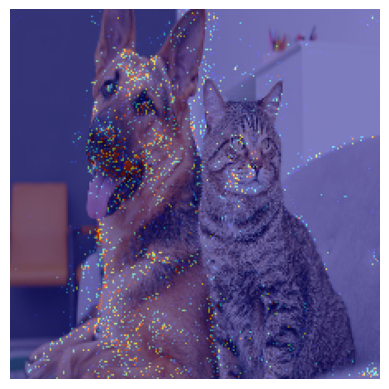

In [ ]:
from techniques.generate_grounding import gen_grounding, gen_all_groundings
ig_expl_dog = gen_grounding(resized_image,
                       'ig',
                       orig_model,
                       show=True,
                       save=True,
                       target_index=242,
                       save_path=save_path+'dog',
                       device=0,
                       index=True)

result path: ../cat_dog/cat/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


integrated gradients clasification: tiger_cat
finished Integrated Gradients explanation
changed
saving explanation mask....

saved to ../cat_dog/cat/ig-vgg19


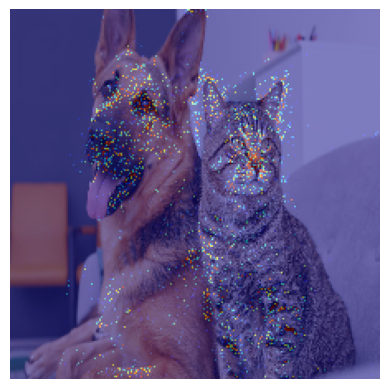

In [ ]:
ig_expl_dog = gen_grounding(resized_image,
                       'ig',
                       orig_model,
                       show=True,
                       save=True,
                       target_index=282,
                       save_path=save_path+'cat',
                       device=0,
                       index=True)

### Vanilla Backpropagation explanations

result path: ../cat_dog/dog/
saving explanation mask....

saved to ../cat_dog/dog/bp-vgg19


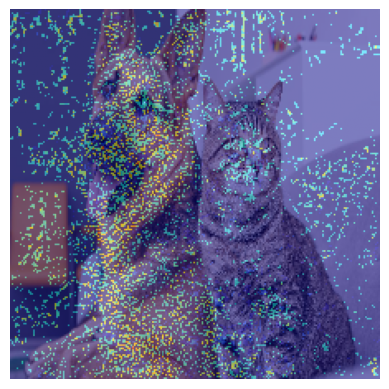

In [ ]:
#generate image wrt a specific class index
bp_expl_dog = gen_grounding(resized_image,
                            'bp',
                            orig_model,
                            target_index=242,
                            show=True,
                            save=True,
                            save_path=save_path+'dog',
                            device=0,
                            index=True)

result path: ../cat_dog/cat/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


saving explanation mask....

saved to ../cat_dog/cat/bp-vgg19


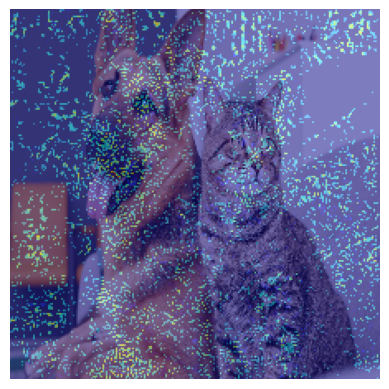

In [ ]:
#generate image wrt a specific class index
bp_expl_dog = gen_grounding(resized_image,
                            'bp',
                            orig_model,
                            target_index=282,
                            show=True,
                            save=True,
                            save_path=save_path+'cat',
                            device=0,
                            index=True)

### Guided Backpropagation explanations

result path: ../cat_dog/dog/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args

saving explanation mask....

saved to ../cat_dog/dog/gbp-vgg19


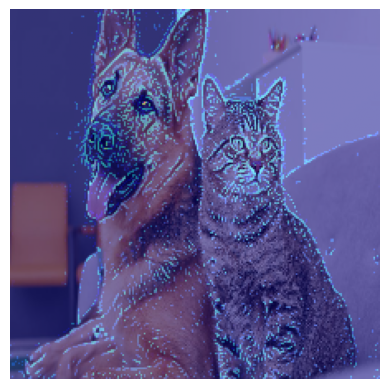

In [ ]:
#generate image wrt a specific class index
gbp_expl_dog = gen_grounding(resized_image,
                            'gbp',
                            orig_model,
                            target_index=242,
                            show=True,
                            save=True,
                            save_path=save_path+'dog',
                            device=0,
                            index=True)

result path: ../cat_dog/cat/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args

saving explanation mask....

saved to ../cat_dog/cat/gbp-vgg19


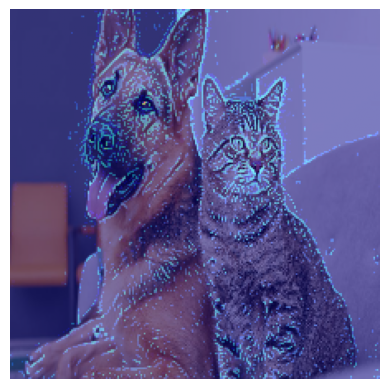

In [ ]:
#generate image wrt a specific class index
gbp_expl_cat = gen_grounding(resized_image,
                            'gbp',
                            orig_model,
                            target_index=282,
                            show=True,
                            save=True,
                            save_path=save_path+'cat',
                            device=0,
                            index=True)

### Deconvolution explanations

result path: ../cat_dog/dog/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args

saving explanation mask....

saved to ../cat_dog/dog/deconv-vgg19


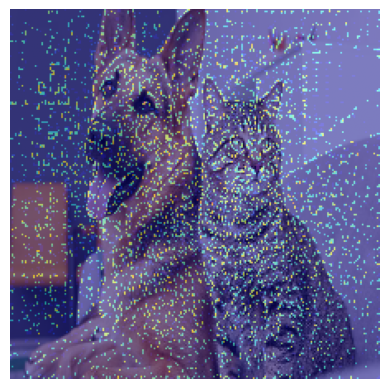

In [ ]:
#generate image wrt a specific class index
deconv_expl_dog = gen_grounding(resized_image,
                            'deconv',
                            orig_model,
                            target_index=242,
                            show=True,
                            save=True,
                            save_path=save_path+'dog',
                            device=0,
                            index=True)

result path: ../cat_dog/cat/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args

saving explanation mask....

saved to ../cat_dog/cat/deconv-vgg19


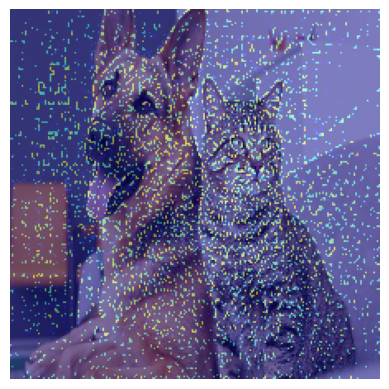

In [ ]:
#generate image wrt a specific class index
deconv_expl_cat = gen_grounding(resized_image,
                            'deconv',
                            orig_model,
                            target_index=282,
                            show=True,
                            save=True,
                            save_path=save_path+'cat',
                            device=0,
                            index=True)

## === Generate All Explanation Methods at Once ===

result path: ./cat_dog/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Generating filters: 100%|██████████| 6000/6000 [00:14<00:00, 405.90it/s]


Masks are generated.
finished RISE
saving explanation mask....

saved to ./cat_dog/rise-vgg19
result path: ./cat_dog/


  0%|          | 0/1000 [00:00<?, ?it/s]

lime classsification: 235
finished lime explanation
saving explanation mask....

saved to ./cat_dog/lime-vgg19
result path: ./cat_dog/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args

	#0: German_shepherd (0.24988)
saving explanation mask....

saved to ./cat_dog/gcam-vgg19
result path: ./cat_dog/
	#0: German_shepherd (0.24988)
saving explanation mask....

saved to ./cat_dog/bp-vgg19
result path: ./cat_dog/
	#0: German_shepherd (0.24988)
saving explanation mask....

saved to ./cat_dog/gbp-vgg19
result path: ./cat_dog/
	#0: German_shepherd (0.24988)
saving explanation mask....

saved to ./cat_dog/deconv-vgg19
result path: ./cat_dog/
integrated gradients clasification: German_shepherd
finished Integrated Gradients explanation
changed
saving explanation mask....

saved to ./cat_dog/ig-vgg19


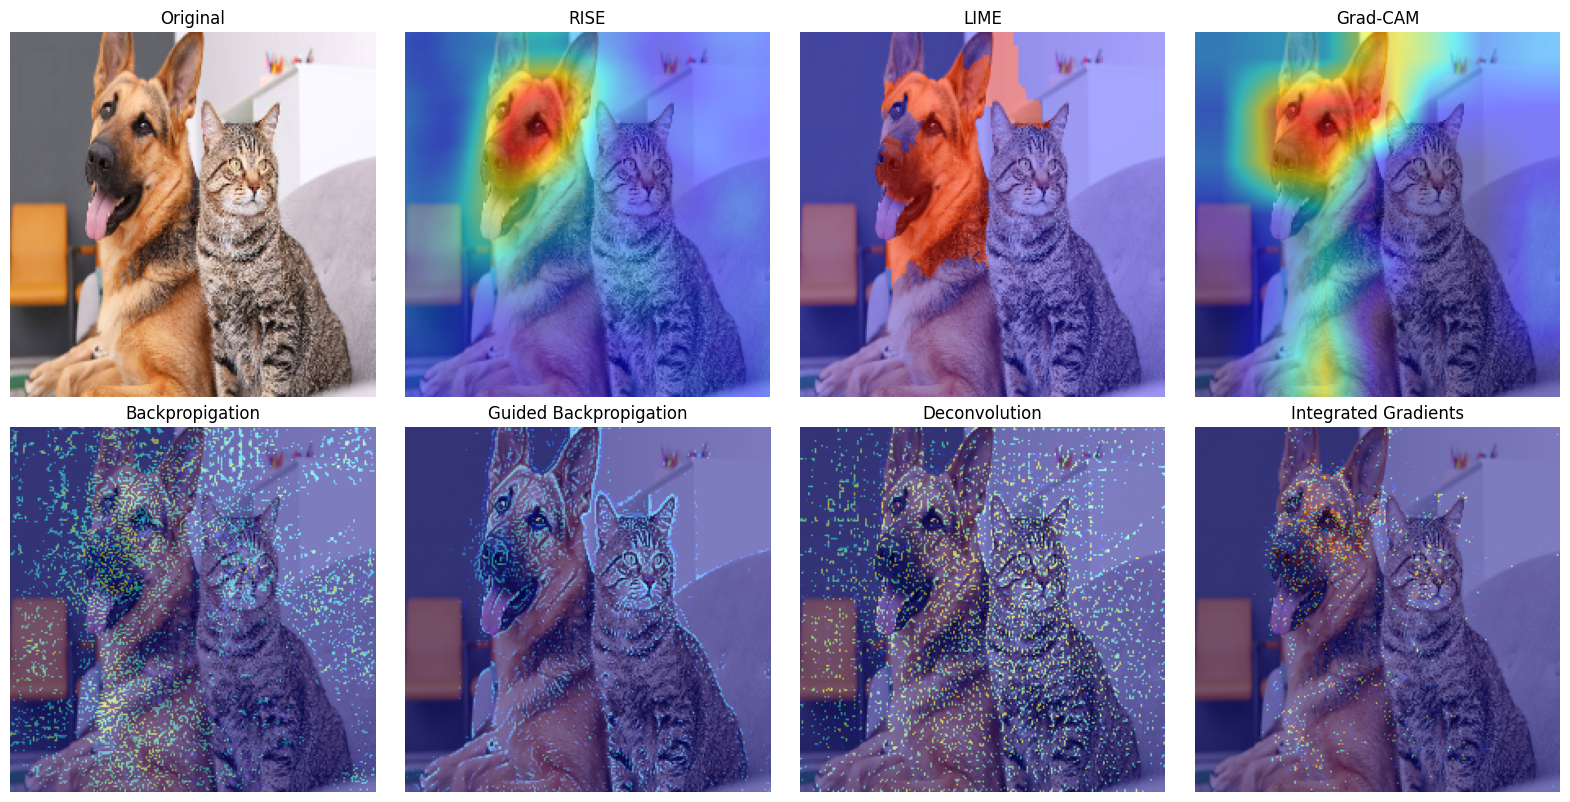

In [ ]:
#generate image wrt a specific class index
all_expl_dog = gen_all_groundings(resized_image,
                              orig_model,
                              target_index=1,
                              show=True,
                              save=True,
                              save_path='./cat_dog',
                              device=0,
                              index=False)